In [2]:
import pandas as pd
import numpy as np
import sys
from data_science import PrepTools, ModelSelectionTools
sys.path.append("/Users/atticussoane/Retrosheet/tools/")
from recursive_selection import FeatureSelector
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [3]:
adv = pd.read_csv("./adv_metrics/all_metrics_with_odds.csv.gz", compression = "gzip", low_memory = False, 
                 index_col = 0)

pd.set_option("max.columns", 200)

adv.head()

,date,home_close_TJ,home_close_ou,home_closing,home_open_TJ,home_open_ou,home_opening,home_runline,home_runline_juice,is_doubleheader,road_close_TJ,road_close_ou,road_closing,road_open_TJ,road_open_ou,road_opening,road_runline,road_runline_juice,is_tripleheader,season,home_team,road_team,home_starter,road_starter,home_wOBA,home_wRAA,home_wRC,home_OPS,home_relief_wOBA,home_relief_wRAA,home_relief_wRC,home_relief_FIP,home_relief_WHIP,home_relief_ERA,home_relief_K_BB,home_relief_K_9,home_starter_career_wOBA,home_starter_career_wRAA,home_starter_career_wRC,home_starter_career_FIP,home_starter_career_WHIP,home_starter_career_ERA,home_starter_careerK/BB,home_starter_careerK/9,home_starter_career_AVGIP,home_starter_season_wOBA,home_starter_season_wRAA,home_starter_season_wRC,home_starter_season_FIP,home_starter_season_WHIP,home_starter_season_ERA,home_starter_seasonK/BB,home_starter_seasonK/9,home_starter_seasonAVG_IP,road_wOBA,road_wRAA,road_wRC,road_OPS,road_relief_wOBA,road_relief_wRAA,road_relief_wRC,road_relief_FIP,road_relief_WHIP,road_relief_ERA,road_relief_K_BB,road_relief_K_9,road_starter_career_wOBA,road_starter_career_wRAA,road_starter_career_wRC,road_starter_career_FIP,road_starter_career_WHIP,road_starter_career_ERA,road_starter_careerK/BB,road_starter_careerK/9,road_starter_career_AVGIP,road_starter_season_wOBA,road_starter_season_wRAA,road_starter_season_wRC,road_starter_season_FIP,road_starter_season_WHIP,road_starter_season_ERA,road_starter_seasonK/BB,road_starter_seasonK/9,road_starter_seasonAVG_IP,home_payout,road_payout,elo1_pre,elo2_pre,rating1_pre,rating2_pre,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,score1,score2,home_win,home_favorite,line_movement,money_scalar
0,2010-04-04,-115,9,-117.0,-104,9.0,-114.0,NaN,NaN,0,-105,9,107.0,-116,9.0,104.0,NaN,NaN,0.0,2010.0,BOS,NYY,beckj002,sabac001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.854701,2.070000,1537.262,1568.875,1536.601,1562.673,57.031,61.828,27.349300,46.7039,0.471714,9.0,7.0,1,1,1,-3.0
1,2010-04-05,105,7.5,175.0,-120,7.5,175.0,NaN,NaN,0,-125,7.5,-200.0,100,7.5,-200.0,NaN,NaN,0.0,2010.0,WSN,PHI,lannj001,hallr001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.750000,1.500000,1460.859,1541.211,1460.662,1537.875,49.834,62.166,8.394200,49.4957,0.366599,1.0,11.0,0,0,0,0.0
2,2010-04-05,-105,7,137.0,-105,7.0,110.0,NaN,NaN,0,-115,7,-152.0,-115,7.0,-125.0,NaN,NaN,0.0,2010.0,OAK,SEA,sheeb001,hernf002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.370000,1.657895,1509.222,1501.778,1513.910,1500.945,56.701,60.524,7.593298,46.4172,0.501246,3.0,5.0,0,0,-1,27.0
3,2010-04-05,110,8.5,-128.0,100,8.5,-135.0,NaN,NaN,0,-130,8.5,113.0,-120,8.5,120.0,NaN,NaN,0.0,2010.0,ANA,MIN,weavj003,bakes002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.781250,2.130000,1544.703,1521.978,1543.114,1520.771,54.034,55.637,16.337200,26.8276,0.550540,6.0,3.0,1,1,-1,7.0
4,2010-04-05,-115,7,-122.0,-115,7.0,-115.0,NaN,NaN,0,-105,7,112.0,-105,7.0,105.0,NaN,NaN,0.0,2010.0,KCR,DET,greiz001,verlj001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [4]:
add_on = pd.read_csv("./all_features.csv.gz", compression = "gzip")

In [5]:
to_keep = ["batting_park_factor", "current_streak_hm_tm", "current_streak_hm_at_hm", "home_record_hm",
          "run_differential_hm", "avg_margin_hm", "distance_traveled", "current_streak_rd_tm", 
           "current_streak_rd_tm_on_rd", 
          "rd_record_rd", "run_differential_rd", "avg_margin_rd", "team1", "team2", "is_doubleheader", 
          "date"]

add_on.date = pd.to_datetime(add_on.date, format = "%Y-%m-%d")

add_on["year"] = pd.DatetimeIndex(add_on.date).year

add_on = add_on[add_on.year >= 2010].reset_index(drop=True)[to_keep]

In [6]:
add_on = add_on.rename(columns = {
    
    "current_streak_hm_tm" : "home_streak",
    
    "current_streak_hm_at_hm" : "home_H_streak",
    
    "home_record_hm" : "home_record",
    
    "current_streak_rd_tm" : "road_streak",
    
    "current_streak_rd_tm_on_rd" : "road_R_streak",
    
    "rd_record_rd" : "road_record",
    
    "team1" : "home_team", 
    
    "team2" : "road_team"
})

adv.date = pd.to_datetime(adv.date, format = "%Y-%m-%d")

merge_cols = ["date", "is_doubleheader", "home_team", "road_team"]

adv = adv.merge(add_on, how = "left", left_on = merge_cols, right_on = merge_cols)

del add_on

In [7]:
print(adv.columns[2], adv.columns[11])

home_close_ou road_close_ou


In [8]:
try:
    
    adv.home_close_ou.astype("float32")
    
except Exception as e:
    
    print(e)

could not convert string to float: '9½'


In [9]:
for k in range(len(adv)):
    
    try:
        
        float(adv.iloc[k]["home_close_ou"]), float(adv.iloc[k]["road_close_ou"])
        
    except Exception as e:
        
        print(e)

could not convert string to float: '9½'
could not convert string to float: '8½'
could not convert string to float: '8½'
could not convert string to float: '8½'
could not convert string to float: '8½'
could not convert string to float: '8½'
could not convert string to float: '7½'


In [10]:
replace_map = {
    
    "9½" : 9.5,
    
    "8½" : 8.5,
    
    "7½" : 7.5
}

adv = adv.replace(replace_map)

cols = ["home_close_ou", "road_close_ou"]

for col in cols:
    
    adv[col] = adv[col].astype("float32")

In [14]:
adv.to_csv("./adv_metrics/current.csv.gz", compression = "gzip", index = False)

# Line Prediction

A betting line is nothing more than an implied win probability. For example, let's take a favorite line of $-185$. We can convert this to an implied win probability as follows: $$\frac{1}{1 + \frac{100}{185}}\:=\: 0.64912$$. A $+185$ underdog line would be calculated as follows: $$\frac{1}{\frac{185}{100} + 1}\:=\: 0.350877$$ Now, this yields another opportunity to frame this as a binary classification problem and determine an arbitrage strategy. If I can generate unbiased outcome predictions based on GAME data, not gambling data (I think I'm going to include the opening line as a feature but if that starts getting too leaky I'll dial that back), I can convert the expected win probabilities into American style gambling lines and compare my generated lines to the actual lines and look for large discrepancies. As we have discussed, gambling lines are not designed to accurately predict outcome. They are designed to accurately predict BETTORS... For example, popular teams are often over-valued for the simple fact that more money is placed on them and bookmakers need to protect themselves from losses if that team wins. More bets will always be placed on the Yankees than the Devil Rays.  

Now, we need a benchmark for accuracy (the classes distribution is $(0.53, 0.47)$ so in this case accuracy is a fine metric this is not a class imbalance situation where precision would be necessary). We already know the FiveThirtyEight ratings are around $60\%$ accuracy. But nobody is setting the lines off of FiveThirtyEight (although maybe they should), we need to know how accurate the bookmakers are before we know how accurate we need to be. We can run a simple test to determine this.

In [2]:
adv = pd.read_csv("./adv_metrics/current.csv.gz", compression = "gzip")

In [11]:
def implied_probability(lines: pd.core.frame.Series):
    
    probs = []
    
    for k in range(len(lines)):
        
        if lines[k] > 0:
            
            prob = 1. / ( (lines[k] / 100.) + 1)
            
        else:
            
            prob = 1. / ( (100. / -lines[k]) + 1)
            
        probs.append(prob)
        
    return(pd.Series(probs))

bookie_probs = implied_probability(adv.home_closing)

In [12]:
bookie_probs = bookie_probs.rename("bookmaker_win_prob")

bookmaker_test = pd.concat([bookie_probs, adv.home_win], axis = 1)

bookmaker_acc = len(bookmaker_test[((bookmaker_test.bookmaker_win_prob > 0.5) &
                                  (bookmaker_test.home_win == 1)) |
                                  ((bookmaker_test.bookmaker_win_prob < 0.5) &
                                  (bookmaker_test.home_win == 0))]) / len(bookmaker_test)

print("The bookmaker implied probability yields an accuracy of: {}".format(round(bookmaker_acc, 2)))

The bookmaker implied probability yields an accuracy of: 0.57


So $57\%$ is the bare minimum we need to strive for. However, this does not tell the whole story. Again, we are looking for VALUE not ACCURACY... If we hit on on anything over $+200$, we can survive at anything over $50\%$... Thus, if we can play underdogs with an accuracy of $57\%$, we are in excellent shape.

Next, we need to select a feature set that does not use the CLOSING line as a feature... We can use the opening line.

In [13]:
pd.set_option("max.columns", 200)

drop_cols = ["home_close_TJ", "home_close_ou", "home_closing", "home_open_TJ", "home_open_ou", "home_runline",
            "home_runline_juice", "is_doubleheader", "road_close_TJ", "road_close_ou", "road_closing",
            "road_open_TJ", "road_open_ou", "road_opening", "road_runline", "road_runline_juice", 
            "is_tripleheader", "home_team", "road_team", "home_starter", "road_starter", "home_payout", 
            "road_payout", "elo1_pre", "elo2_pre", "rating_prob1", "score1", "score2", "home_favorite",
            "line_movement", "money_scalar", "date", "season"]

training = adv[adv.season < 2019].drop(columns = drop_cols).reset_index(drop = True)

validation = adv[adv.season == 2019].drop(columns = drop_cols).reset_index(drop = True)

In [14]:
train_target = training.home_win

training = training.drop("home_win", axis = 1)

validation_target = validation.home_win

validation = validation.drop("home_win", axis = 1)

In [15]:
#convert opening lines to payouts (necessary to use with scaler, otherwise features can't be scaled)
def convert_to_payout(lines: pd.core.frame.DataFrame):
    
    payouts = []
    
    for k in range(len(lines)):
        
        if lines[k] < 0:
            
            payout = 1. + (100. / -lines[k])
            
        else:
            
            payout = lines[k] / 100. + 1
            
        payouts.append(payout)
        
    return(pd.Series(payouts))
            
open_payoutsT = convert_to_payout(training.home_opening).rename("home_payout")

open_payoutsV = convert_to_payout(validation.home_opening).rename("home_payout")         

In [16]:
training = pd.concat([training, open_payoutsT], axis = 1).drop("home_opening", axis = 1)

validation = pd.concat([validation, open_payoutsV], axis = 1).drop("home_opening", axis = 1)

In [17]:
try:
    
    xtrain, ss = PrepTools(training, train_target).scale_features(save_scaler = True)

    xtest = PrepTools(validation, validation_target).scale_features(load_scaler = ss)
    
except Exception as e:
    
    print(e)

Input contains infinity or a value too large for dtype('float64').


In [18]:
for col in training.columns:
    
    if training[col].max() > 50000:
        
        print(col, training[col].max())
        
    if validation[col].max() > 50000:
        
        print(col, training[col].max(), "validation")

home_starter_career_FIP inf
home_starter_career_WHIP inf
home_starter_career_ERA inf


In [19]:
training[(training.home_starter_career_FIP == np.inf) |
        (training.home_starter_career_WHIP == np.inf) |
        (training.home_starter_career_ERA == np.inf)]

,home_wOBA,home_wRAA,home_wRC,home_OPS,home_relief_wOBA,home_relief_wRAA,home_relief_wRC,home_relief_FIP,home_relief_WHIP,home_relief_ERA,home_relief_K_BB,home_relief_K_9,home_starter_career_wOBA,home_starter_career_wRAA,home_starter_career_wRC,home_starter_career_FIP,home_starter_career_WHIP,home_starter_career_ERA,home_starter_careerK/BB,home_starter_careerK/9,home_starter_career_AVGIP,home_starter_season_wOBA,home_starter_season_wRAA,home_starter_season_wRC,home_starter_season_FIP,home_starter_season_WHIP,home_starter_season_ERA,home_starter_seasonK/BB,home_starter_seasonK/9,home_starter_seasonAVG_IP,road_wOBA,road_wRAA,road_wRC,road_OPS,road_relief_wOBA,road_relief_wRAA,road_relief_wRC,road_relief_FIP,road_relief_WHIP,road_relief_ERA,road_relief_K_BB,road_relief_K_9,road_starter_career_wOBA,road_starter_career_wRAA,road_starter_career_wRC,road_starter_career_FIP,road_starter_career_WHIP,road_starter_career_ERA,road_starter_careerK/BB,road_starter_careerK/9,road_starter_career_AVGIP,road_starter_season_wOBA,road_starter_season_wRAA,road_starter_season_wRC,road_starter_season_FIP,road_starter_season_WHIP,road_starter_season_ERA,road_starter_seasonK/BB,road_starter_seasonK/9,road_starter_seasonAVG_IP,rating1_pre,rating2_pre,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,batting_park_factor,home_streak,home_H_streak,home_record,run_differential_hm,avg_margin_hm,distance_traveled,road_streak,road_R_streak,road_record,run_differential_rd,avg_margin_rd,home_payout
4407,0.320677,19.331178,101.527427,0.729986,0.322646,8.75501,102.876765,3.944715,1.399224,4.244838,2.510949,8.112357,0.694,0.598101,357.982735,inf,inf,inf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.307764,-33.535382,90.980156,0.700441,0.294388,-30.468379,81.813983,3.601214,1.231745,3.422293,2.714286,7.978351,0.339689,3.317247,111.668812,5.474388,1.374656,6.073482,1.5625,5.623594,5.00125,0.339689,3.317247,111.668812,5.474388,1.374656,6.073482,1.5625,5.623594,5.00125,1500.867,1469.393,43.208,45.575,11.453842,5.156482,96.0,1.0,1.0,-7.0,-19.0,0.0,0.0,-1.0,-1.0,2.0,-34.0,0.0,1.909091


In [20]:
training = training.drop(4407, axis = 0).reset_index(drop = True)

train_target = train_target.drop(4407, axis = 0).reset_index(drop = True)

In [21]:
len(training), len(train_target)

(21554, 21554)

In [22]:
xtrain, ss = PrepTools(training, train_target).scale_features(save_scaler = True)

xtest = PrepTools(validation, validation_target).scale_features(load_scaler = ss)

# RECURSIVE FEATURE SELECTOR EXPERIMENTATION

With such a large feature set, feature selection is critical. Dimensionality reduction may be critical too, but I will start with feature selection.

### Logistic Regression

In [23]:
lr = {
    
    "X" : xtrain,
    
    "y" : train_target,
    
    "algorithm" : LogisticRegression(),
    
    "params" : {
        
        "penalty" : "l1",
        
        "solver" : "liblinear", 
        
        "fit_intercept" : False,
        
        "C" : 1.0
    }
    
}

selector = FeatureSelector(**lr)

In [24]:
selector.recursive_selection()

'Cannot reduce feature frame anymore. Reduce drop size if desired'

In [25]:
lr_l1_penalty_subset, lr_l1_penalty_score = list(selector.best_subset), selector.best_eval

In [27]:
lr = {
    
    "X" : xtrain,
    
    "y" : train_target,
    
    "algorithm" : LogisticRegression(),
    
    "params" : {
        
        "penalty" : "l2",
        
        "solver" : "lbfgs", 
        
        "C" : 1.0,
        
        "fit_intercept" : False,
        
        "max_iter" : 1000
    }
}

selector = FeatureSelector(**lr)

In [28]:
selector.recursive_selection()

'Cannot reduce feature frame anymore. Reduce drop size if desired'

In [29]:
lr_l2_penalty_subset, lr_l2_penalty_score = list(selector.best_subset), selector.best_eval

In [30]:
XGBClassifier().get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [31]:
xgb = {
    
    "X" : xtrain,
    
    "y" : train_target, 
    
    "algorithm" : XGBClassifier(), 
    
    "params" : {
        
        "max_depth" : 3,
        
        "reg_alpha" : 1,
        
        "reg_lambda" : 0,
        
        "colsample_bytree" : 0.6
    }
}

selector = FeatureSelector(**xgb)

In [32]:
selector.recursive_selection()

'Cannot reduce feature frame anymore. Reduce drop size if desired'

In [33]:
xgb_features, xgb_eval = list(selector.best_subset), selector.best_eval

In [34]:
xgb_train = xtrain[xgb_features]

xgb_test = xtest[xgb_features]

In [36]:
xPrep = PrepTools(xgb_train, train_target)

target_corr = xPrep.get_correlation_with_target(target_name = "home_win")

target_corr

home_payout               home_win    0.157845
rating2_pre               home_win    0.101288
rating1_pre               home_win    0.090981
pitcher2_rgs              home_win    0.087381
run_differential_rd       home_win    0.082940
pitcher1_rgs              home_win    0.082734
road_starter_season_wRAA  home_win    0.067790
road_starter_career_wRAA  home_win    0.066878
home_starter_season_wRAA  home_win    0.063046
home_starter_career_wRAA  home_win    0.062216
road_wRAA                 home_win    0.052116
home_starter_careerK/9    home_win    0.049024
road_starter_seasonK/9    home_win    0.048367
road_starter_seasonK/BB   home_win    0.043588
home_relief_wRC           home_win    0.040297
road_starter_season_wRC   home_win    0.039710
road_relief_K_9           home_win    0.035735
road_relief_FIP           home_win    0.035402
road_relief_wRC           home_win    0.033051
home_relief_FIP           home_win    0.032788
road_relief_WHIP          home_win    0.031846
road_relief_w

In [51]:
top_features = [i[0] for i in target_corr.index[:10]]

In [41]:
top_features

['home_payout',
 'rating2_pre',
 'rating1_pre',
 'pitcher2_rgs',
 'run_differential_rd',
 'pitcher1_rgs',
 'road_starter_season_wRAA',
 'road_starter_career_wRAA',
 'home_starter_season_wRAA',
 'home_starter_career_wRAA']

In [47]:
x = np.arange(len(top_features))

In [55]:
top_vals = [round(i, 3) for i in list(target_corr.values[:10])]

In [56]:
top_vals

[0.158, 0.101, 0.091, 0.087, 0.083, 0.083, 0.068, 0.067, 0.063, 0.062]

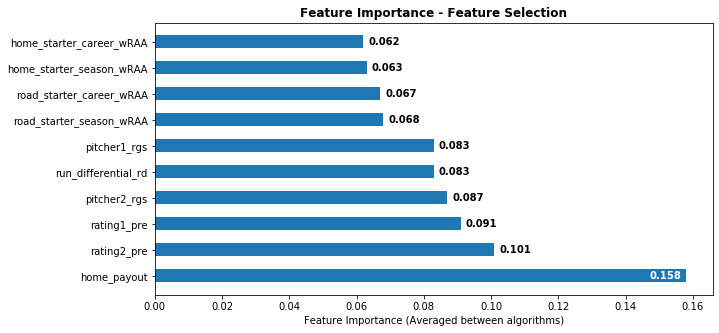

In [65]:
fig, ax1 = plt.subplots(figsize = (10, 5))

rects = ax1.barh(x, top_vals,
                     align='center',
                     height=0.5,
                tick_label = top_features)

for rect in rects:
    width = rect.get_width()
    lbl = "{}".format(str(width))
    if width < 0.14:
        xshift = 5
        c = "black"
        align = "left"
    else:
        xshift = -5
        c = "white"
        align = "right"

    yshift = rect.get_y() + rect.get_height() / 2

    label = ax1.annotate(lbl, xy=(width, yshift), xytext=(xshift, 0),
                        textcoords="offset points",
                        ha=align, va='center',
                        color=c, weight='bold', clip_on=True)

ax1.set_title("Feature Importance - Feature Selection", weight = "bold")

ax1.set_xlabel("Feature Importance (Averaged between algorithms)")

plt.savefig("./adv_metrics/adv_metric_plots/feature_importance");

In [67]:
Xcorr = xPrep.feature_frame_correlation()

highly_correlated = Xcorr[Xcorr > 0.75]

In [70]:
corr_indices = []

for i in highly_correlated.index[:10]:
    
    corr_indices.append(str(i))

In [78]:
corr_vals = list(highly_correlated.values[:10])

corr_vals = [round(i, 3) for i in corr_vals]

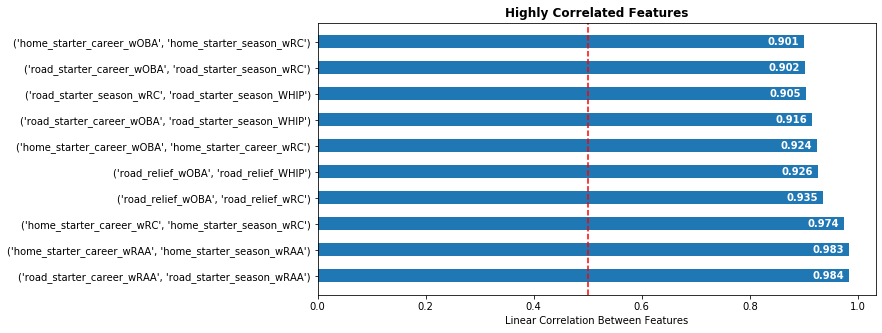

In [86]:
fig, ax1 = plt.subplots(figsize = (10, 5))

rects = ax1.barh(x, corr_vals,
                     align='center',
                     height=0.5,
                tick_label = corr_indices)

for rect in rects:
    width = rect.get_width()
    lbl = "{}".format(str(width))
    if width < 0.14:
        xshift = 5
        c = "black"
        align = "left"
    else:
        xshift = -5
        c = "white"
        align = "right"

    yshift = rect.get_y() + rect.get_height() / 2

    label = ax1.annotate(lbl, xy=(width, yshift), xytext=(xshift, 0),
                        textcoords="offset points",
                        ha=align, va='center',
                        color=c, weight='bold', clip_on=True)
    
ax1.axvline(0.5, ls = "--", c = "r")

ax1.set_title("Highly Correlated Features", weight = "bold")

ax1.set_xlabel("Linear Correlation Between Features")

plt.savefig("./adv_metrics/adv_metric_plots/correlation");

In [83]:
Xvif = xPrep.recursive_VIF(tol = 5.0)

In [84]:
Xvif

[('home_starter_career_wRAA', 33.151208393948416),
 ('road_starter_career_wRAA', 32.55314348345556),
 ('home_starter_career_wRC', 30.501614627518897),
 ('road_relief_wOBA', 24.27761023314412),
 ('road_starter_season_wRC', 10.714747128873233),
 ('home_starter_career_wOBA', 9.023929268310662),
 ('road_starter_career_wOBA', 7.423984646367683),
 ('road_relief_wRC', 6.603343997932336),
 ('home_payout', 5.170604211918051)]

In [97]:
vif_feature = []

vif = []

for i in Xvif:
    
    vif_feature.append(i[0])
    
    vif.append(i[1])
    
vif = [round(i, 3) for i in vif]

In [94]:
x = np.arange(len(vif_feature))

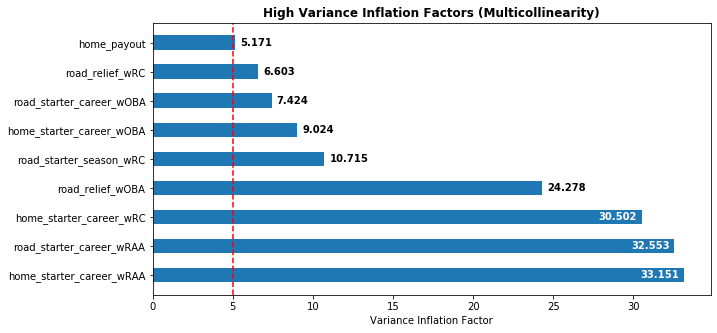

In [98]:
fig, ax1 = plt.subplots(figsize = (10, 5))

rects = ax1.barh(x, vif,
                     align='center',
                     height=0.5,
                tick_label = vif_feature)

for rect in rects:
    width = rect.get_width()
    lbl = "{}".format(str(width))
    if width < 30:
        xshift = 5
        c = "black"
        align = "left"
    else:
        xshift = -5
        c = "white"
        align = "right"

    yshift = rect.get_y() + rect.get_height() / 2

    label = ax1.annotate(lbl, xy=(width, yshift), xytext=(xshift, 0),
                        textcoords="offset points",
                        ha=align, va='center',
                        color=c, weight='bold', clip_on=True)
    
ax1.axvline(5.0, ls = "--", c = "r")

ax1.set_title("High Variance Inflation Factors (Multicollinearity)", weight = "bold")

ax1.set_xlabel("Variance Inflation Factor")

plt.savefig("./adv_metrics/adv_metric_plots/VIF");

In [90]:
import json

with open("./for_xgb.json", "w") as f:
    json.dump(xgb_features, f)

In [91]:
drop_cols = [
    
    "road_starter_career_wRAA",
    
    "home_starter_career_wRAA",
    
    "road_relief_wOBA",
    
    "home_starter_career_wOBA",
    
    "road_starter_career_wOBA",
    
    "road_starter_season_WHIP",
    
    "road_relief_WHIP"
    
]

In [92]:
with open("./potential_xgb_drop_cols.json", "w+") as f:
    
    json.dump(drop_cols, f)

In [32]:
xgb_train = xgb_train.drop(columns = drop_cols)

xgb_test = xgb_test.drop(columns = drop_cols)

# Had to edit source for GridSearch wrapper, reloading...

Using custom wrapper for sklearn GridSearchCV for LogisticRegression model with few hyperparameters... will use Hyperopt for algorithms with more hyperparameters. 

In [72]:
working_feature_set = list(xgb_train.columns)
xgb_train.to_csv("./working_train.csv.gz", index = False, compression = "gzip")
xgb_test.to_csv("./working_test.csv.gz", index = False, compression = "gzip")

In [71]:
import json
with open("./adv_metrics/current_XGB_features.json", "w+") as f:
    json.dump(working_feature_set, f)

['home_relief_wRC',
 'home_relief_FIP',
 'home_starter_career_wRC',
 'home_starter_careerK/9',
 'home_starter_season_wRAA',
 'home_starter_season_wRC',
 'road_wRAA',
 'road_relief_wRC',
 'road_relief_FIP',
 'road_relief_K_9',
 'road_starter_season_wRAA',
 'road_starter_season_wRC',
 'road_starter_seasonK/BB',
 'road_starter_seasonK/9',
 'rating1_pre',
 'rating2_pre',
 'pitcher1_rgs',
 'pitcher2_rgs',
 'run_differential_rd',
 'home_payout']

In [11]:
m = ModelSelectionTools(xgb_train, train_target)

In [3]:
xgb_train = pd.read_csv("./working_train.csv.gz", compression = "gzip")
xgb_test = pd.read_csv("./working_test.csv.gz", compression = "gzip")

In [12]:
search_params = {
    
    "solver" : ["liblinear", "lbfgs"],
    
    "C" : [0.001, 0.01, 0.1, 1.0, 10.]
    
}

init_params = {
    
    "penalty" : "l2",
    
    "fit_intercept" : False,
    
    "max_iter" : 1000
}

score, params, results = m.grid_search(LogisticRegression(), init_params, search_params)

In [13]:
l2_score, l2_params = score, params

In [14]:
search_params = {
    
    "C" : [0.0001, 0.001, 0.01, 0.1, 1.0, 10.]
}

init_params = {
    
    "penalty" : "l1",
    
    "solver" : "liblinear", 
    
    "fit_intercept" : False
}

score, params, results = m.grid_search(LogisticRegression(), init_params, search_params)

In [15]:
l1_score, l1_params = score, params

In [39]:
from hyperopt import fmin, tpe, hp, STATUS_OK, STATUS_FAIL, Trials
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample
from sklearn.model_selection import cross_val_score
from concurrent.futures import ProcessPoolExecutor
from dataclasses import dataclass, field
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_auc_score

In [69]:
hyperopt_space = {
    
    "max_depth" : scope.int(hp.uniform("max_depth", 2, 5)),
    
    "learning_rate" : hp.loguniform("learning_rate", np.log(0.01), np.log(0.20)),
    
    "reg_alpha" : hp.uniform("reg_alpha", 0., 1.),
    
    "reg_lambda" : hp.uniform("reg_lambda", 0., 1.),
    
    "col_sample_by_tree" : hp.loguniform("col_sample_by_tree", np.log(0.6), np.log(1.0)),
}

def optimize(space, xtrain, ytrain, num_eval):
    
    def objective(params):

        try:

            xgb = XGBClassifier().set_params(**params)

            score = cross_val_score(xgb, xtrain, ytrain, cv = 5,
                                   scoring = "roc_auc", n_jobs = -1).mean()

            return({"loss" : -score, "status" : STATUS_OK})

        except Exception as e:

            return({"status" : STATUS_FAIL, "exception" : str(e)})

    trials = Trials()

    best_params = fmin(objective, space, algo = tpe.suggest, 
                       max_evals = num_eval, trials = trials)

    return(best_params)



In [70]:
d = optimize(hyperopt_space, xgb_train, train_target, num_eval = 50)

100%|██████████| 50/50 [04:18<00:00,  5.18s/it, best loss: -0.5898670203986969]


In [71]:
d

{'col_sample_by_tree': 0.6995436919949106,
 'learning_rate': 0.022046730333150615,
 'max_depth': 3.988717541952182,
 'reg_alpha': 0.9934530546156045,
 'reg_lambda': 0.336453998210266}

In [77]:
params = {
    
    "col_sample_by_tree" : 0.7,
    
    "learning_rate" : 0.025,
    
    "max_depth" : 4,
    
    "reg_alpha" : 1.,
    
    "reg_lambda" : 0.33
}

xgb2 = XGBClassifier().set_params(**params)

xgb2.fit(xgb_train, train_target)

xgb_preds2 = xgb2.predict(xgb_test)

print("Accuracy on test data: {}".format(round(accuracy_score(validation_target, xgb_preds), 4)))

Accuracy on test data: 0.6019


In [75]:
xgb1_winprobs = xgb.predict_proba(xgb_test)

In [81]:
home_winprobs = [i[0] for i in xgb1_winprobs]

In [96]:
vegas_lines = adv[(adv.season == 2019)].home_closing.reset_index(drop = True)

len(vegas_lines)

2384

In [99]:
home_win = adv[adv.season == 2019].home_win.reset_index(drop = True)

In [109]:
dates = adv[adv.season == 2019].date.reset_index(drop = True)

road_lines = adv[adv.season == 2019].road_closing.reset_index(drop = True)

In [45]:
def line_from_probability(probs: list):
    
    lines = []
    
    for prob in probs:
        
        if prob > 0.50:
        
            lines.append( -int( (1 / prob) * 100))
            
        else:
            
            lines.append( int( (1 / prob)*100 - 100))
        
    return(pd.Series(lines).rename("model_predicted_lines"))

In [91]:
model_lines = line_from_probability(home_winprobs)

In [100]:
line_comparison = pd.concat([vegas_lines, model_lines, home_win], axis = 1)

In [101]:
line_comparison

,home_closing,model_predicted_lines,home_win
0,-102.0,105,1
1,105.0,-187,0
2,190.0,-148,1
3,-116.0,123,1
4,-117.0,-193,1
...,...,...,...
2379,170.0,-159,1
2380,105.0,-190,0
2381,-165.0,167,0
2382,155.0,-169,0


In [48]:
def calc_plays(vegas: pd.core.frame.Series, model: pd.core.frame.Series):
    
    plays = []
    
    for k in range(len(vegas)):
        
        vegas_line = vegas[k]
        
        model_line = model[k]
        
        if vegas_line < 0 and model_line < vegas_line:
            
            plays.append(1)
            
        elif vegas_line < 0 and model_line > vegas_line:
            
            plays.append(0)
            
        elif vegas_line > 0 and model_line < vegas_line:
            
            plays.append(1)
            
        elif vegas_line > 0 and model_line > vegas_line:
            
            plays.append(0)
            
        elif vegas_line == model_line:
            
            if vegas_line < 0:
                
                plays.append(1)
                
            else:
                
                plays.append(0)
                
    return(plays)

In [106]:
p = calc_plays(line_comparison.home_closing, line_comparison.model_predicted_lines)

In [108]:
from bankroll_calc import BankrollCalculator

In [110]:
len(p), len(home_win), len(vegas_lines), len(road_lines), len(dates)

(2384, 2384, 2384, 2384, 2384)

In [114]:
flip = [0 if i == 1 else 1 for i in p]

In [117]:
bc = BankrollCalculator(p, home_win, dates, vegas_lines, road_lines)

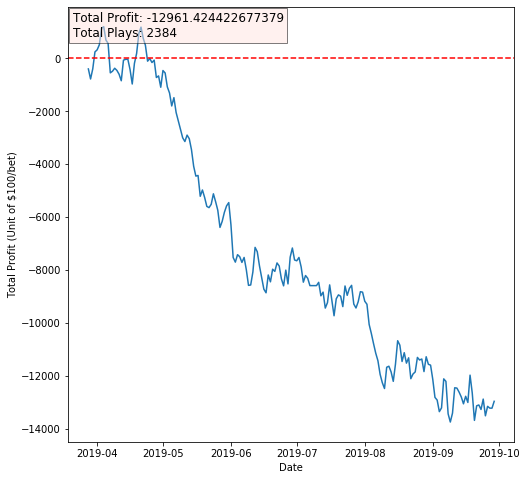

In [118]:
bc.plot_profit()

In [52]:
moneyline_frame = pd.read_csv("./moneyline_frame.csv.gz", compression = "gzip")

In [53]:
pd.set_option('max.columns', 200)

moneyline_frame.head()

,date,home_OBPS,home_AVG_RUNS,home_AVG_H,home_BULLPEN_ERA,home_BULLPEN_WHIP,home_BULLPEN_AVG_INNINGS,home_total_OBPS,home_total_AVG_RUNS,home_total_AVG_H,home_total_BULLPEN_ERA,home_total_BULLPEN_WHIP,home_total_BULLPEN_AVG_INNINGS,road_OBPS,road_AVG_RUNS,road_AVG_H,road_BULLPEN_ERA,road_BULLPEN_WHIP,road_BULLPEN_AVG_INNINGS,road_total_OBPS,road_total_AVG_RUNS,road_total_AVG_H,road_total_BULLPEN_ERA,road_total_BULLPEN_WHIP,road_total_BULLPEN_AVG_INNINGS,home_career_ERA,home_career_WHIP,home_career_AVGIP,home_career_ERA_AH,home_career_WHIP_AH,home_career_AVGIP_AH,home_season_ERA,home_season_WHIP,home_season_AVGIP,home_season_ERA_AH,home_season_WHIP_AH,home_season_AVGIP_AH,road_career_ERA,road_career_WHIP,road_career_AVGIP,road_career_ERA_OR,road_career_WHIP_OR,road_career_AVGIP_OR,road_season_ERA,road_season_WHIP,road_season_AVGIP,road_season_ERA_OR,road_season_WHIP_OR,road_season_AVGIP_OR,elo1_pre,elo2_pre,elo_prob1,rating1_pre,rating2_pre,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,score1,score2,pitching_park_factor,batting_park_factor,TMAX,PRCP,SNOW,SNWD,attendance,current_streak_hm_tm,current_streak_hm_at_hm,home_record_hm,run_differential_hm,avg_margin_hm,distance_traveled,current_streak_rd_tm,current_streak_rd_tm_on_rd,rd_record_rd,run_differential_rd,avg_margin_rd,home_opening,home_closing,total_open,total_openJ,total_close,total_closeJ,road_opening,road_closing,home_win,year,home_payout,road_payout
0,2010-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.798175,1.219565,6.213511,3.872963,1.209871,6.163983,0.0,0.0,0.0,0.0,0.0,0.0,3.644033,1.232144,6.560382,3.686090,1.217175,6.583931,0.0,0.0,0.0,0.0,0.0,0.0,1537.262,1568.875,0.489046,1536.601,1562.673,57.031,61.828,27.349300,46.703900,0.471714,9.0,7.0,105.0,106.0,244.000000,0.0,0.0,0.0,37440.0,0.0,0.0,0.0,0.0,0.0,289.0,0.0,0.0,0.0,0.0,0.0,-114.0,-117.0,9.0,-104.0,9.0,-115.0,104.0,107.0,1,2010,1.854701,2.070000
1,2010-04-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.026421,1.309086,6.071488,3.440926,1.212388,6.378993,0.0,0.0,0.0,0.0,0.0,0.0,3.494632,1.286260,6.438445,3.265724,1.290606,6.430427,0.0,0.0,0.0,0.0,0.0,0.0,1519.750,1505.513,0.554806,1518.661,1505.908,47.147,52.834,8.713313,11.540052,0.552381,16.0,5.0,97.0,98.0,300.000000,0.0,0.0,0.0,53081.0,0.0,0.0,0.0,0.0,0.0,958.0,0.0,0.0,0.0,0.0,0.0,-130.0,-125.0,8.5,-110.0,8.5,-120.0,115.0,110.0,1,2010,1.800000,2.100000
2,2010-04-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.592236,1.303634,6.091569,2.943396,1.169811,6.115385,0.0,0.0,0.0,0.0,0.0,0.0,3.811220,1.317898,6.088554,4.211663,1.387889,5.814419,0.0,0.0,0.0,0.0,0.0,0.0,1495.496,1516.869,0.503780,1496.540,1517.409,53.119,59.030,28.872100,29.196400,0.505293,3.0,5.0,100.0,100.0,255.038764,0.0,0.0,0.0,45808.0,0.0,0.0,0.0,0.0,0.0,1464.0,0.0,0.0,0.0,0.0,0.0,-125.0,-105.0,7.5,-115.0,7.5,-125.0,110.0,-105.0,0,2010,1.952381,1.952381
3,2010-04-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.725154,1.249163,6.105909,3.270368,1.165200,6.282830,0.0,0.0,0.0,0.0,0.0,0.0,4.285186,1.263521,5.953945,4.389571,1.337423,5.927273,0.0,0.0,0.0,0.0,0.0,0.0,1544.703,1521.978,0.566840,1543.114,1520.771,54.034,55.637,16.337200,26.827600,0.550540,6.0,3.0,96.0,96.0,167.000000,30.0,0.0,0.0,43504.0,0.0,0.0,0.0,0.0,0.0,2441.0,0.0,0.0,0.0,0.0,0.0,-135.0,-128.0,8.5,100.0,8.5,110.0,120.0,113.0,1,2010,1.781250,2.130000
4,2010-04-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.398961,1.322743,5.845536,4.441558,1.259740,5.923077,0.0,0.0,0.0,0.0,0.0,0.0,3.846260,1.246243,5.667031,3.933896,1.293336,5.567000,0.0,0.0,0.0,0.0,0.0,0.0,1515.833,1514.391,0.536549,1517.118,1515.563,53.062,54.135,11.637200,17.140900,0.528309,5.0,4.0,108.0,109.0,283.000000,0.0,0.0,0.0,50299.0,0.0,0.0,0.0,0.0,0.0,1959.0,0.0,0.0,0.0,0.0,0.0,-135.0,-1

In [60]:
drop_cols = ["date", "elo1_pre", "elo2_pre", "rating_prob1", "score1", "score2", "pitching_park_factor",
            "TMAX", "PRCP", "SNOW", "SNWD", "attendance", "home_opening", "total_open", "total_openJ", 
            "total_close", "total_closeJ", "road_opening"]

moneyline_frame = moneyline_frame.drop(columns = drop_cols)

training = moneyline_frame[moneyline_frame.year < 2019]

test = moneyline_frame[moneyline_frame.year == 2019].reset_index(drop = True)

In [61]:
train_target, training = training["home_win"], training.drop("home_win", axis = 1)

test_target, test = test["home_win"], test.drop("home_win", axis = 1)

hcT, rcT = training.home_closing, training.road_closing

hcTest, rcTest = test.home_closing.reset_index(drop = True), test.road_closing.reset_index(drop = True)

training = training.drop(columns = ["home_closing", "road_closing"])

test = test.drop(columns = ["home_closing", "road_closing"])

In [12]:
training = training.drop("year", axis = 1)

test = test.drop("year", axis = 1)

In [13]:
len(training), len(train_target), len(test), len(test_target)

(21833, 21833, 2424, 2424)

In [14]:
xtrain, ss = PrepTools(training, train_target).scale_features(save_scaler = True)

xtest = PrepTools(test, test_target).scale_features(load_scaler = ss)

In [16]:
lr = {
    
    "X" : xtrain,
    
    "y" : train_target,
    
    "algorithm" : LogisticRegression(),
    
    "params" : {
        
        "penalty" : "l1",
        
        "solver" : "liblinear", 
        
        "fit_intercept" : False,
        
        "C" : 1.0
    },
    
    "metric" : "roc"
    
}

selector = FeatureSelector(**lr)

In [17]:
selector.recursive_selection()

'Cannot reduce feature frame anymore. Reduce drop size if desired'

In [20]:
l1_subset = list(selector.best_subset)

In [21]:
lr = {
    
    "X" : xtrain,
    
    "y" : train_target,
    
    "algorithm" : LogisticRegression(),
    
    "params" : {
        
        "penalty" : "l2",
        
        "solver" : "lbfgs", 
        
        "fit_intercept" : False,
        
        "max_iter" : 1000,
        
        "C" : 1.0
    },
    
    "metric" : "roc"
    
}

selector = FeatureSelector(**lr)

In [22]:
selector.recursive_selection()

'Cannot reduce feature frame anymore. Reduce drop size if desired'

In [25]:
l2_subset = list(selector.best_subset)

In [26]:
xgb = {
    
    "X" : xtrain,
    
    "y" : train_target,
    
    "algorithm" : XGBClassifier(),
    
    "params" : {
        
            "col_sample_by_tree" : 0.7,
    
            "learning_rate" : 0.025,
    
            "max_depth" : 4,
    
            "reg_alpha" : 1.,
    
            "reg_lambda" : 0.33
    },
    
    "metric" : "roc"
}

selector = FeatureSelector(**xgb)

In [27]:
selector.recursive_selection()

'Cannot reduce feature frame anymore. Reduce drop size if desired'

In [30]:
xgb_subset = list(selector.best_subset)

In [32]:
all_ = l1_subset + l2_subset + xgb_subset

In [37]:
unique = set(all_)

In [38]:
unique

{'elo_prob1',
 'home_BULLPEN_AVG_INNINGS',
 'home_OBPS',
 'home_career_WHIP_AH',
 'home_payout',
 'home_season_AVGIP_AH',
 'pitcher1_rgs',
 'road_career_AVGIP_OR',
 'road_payout',
 'road_season_AVGIP_OR',
 'road_total_BULLPEN_ERA'}

In [40]:
hyperopt_space = {
    
    "max_depth" : scope.int(hp.uniform("max_depth", 2, 5)),
    
    "learning_rate" : hp.loguniform("learning_rate", np.log(0.01), np.log(0.20)),
    
    "reg_alpha" : hp.uniform("reg_alpha", 0., 1.),
    
    "reg_lambda" : hp.uniform("reg_lambda", 0., 1.),
    
    "col_sample_by_tree" : hp.loguniform("col_sample_by_tree", np.log(0.6), np.log(1.0)),
}

def optimize(space, xtrain, ytrain, num_eval):
    
    def objective(params):

        try:

            xgb = XGBClassifier().set_params(**params)

            score = cross_val_score(xgb, xtrain, ytrain, cv = 5,
                                   scoring = "roc_auc", n_jobs = -1).mean()

            return({"loss" : -score, "status" : STATUS_OK})

        except Exception as e:

            return({"status" : STATUS_FAIL, "exception" : str(e)})

    trials = Trials()

    best_params = fmin(objective, space, algo = tpe.suggest, 
                       max_evals = num_eval, trials = trials)

    return(best_params)

d = optimize(hyperopt_space, xtrain[unique], train_target, num_eval = 50)

100%|██████████| 50/50 [02:09<00:00,  2.60s/it, best loss: -0.5959953837975417]


In [41]:
d

{'col_sample_by_tree': 0.8689584878390448,
 'learning_rate': 0.07765057140049818,
 'max_depth': 2.315331058624119,
 'reg_alpha': 0.6970054237849865,
 'reg_lambda': 0.9726467104183162}

In [42]:
xgb = {
    
    "col_sample_by_tree" : 0.9,
    
    "learning_rate" : 0.08,
    
    "max_depth" : 2,
    
    "reg_alpha" : 0.7,
    
    "reg_lambda" : 0.97
}

xgb = XGBClassifier().set_params(**xgb)

xgb.fit(xtrain[unique], train_target)

xgb_preds = xgb.predict(xtest[unique])

print("Accuracy: {}".format(accuracy_score(test_target, xgb_preds)))

Accuracy: 0.6051980198019802


In [80]:
probs = xgb.predict_proba(xtest[unique])

In [81]:
probs = [i[1] for i in probs]

model_lines = line_from_probability(probs)

In [82]:
probs = pd.Series(probs).rename("probs")

In [83]:
model_lines = model_lines.rename("model_lines")

In [85]:
lines_comparison = pd.concat([model_lines, probs, test_target, test_dates, hcTest, rcTest], axis = 1)

In [86]:
lines_comparison

,model_lines,probs,home_win,date,home_closing,road_closing
0,-139,0.718989,1,2019-03-28,-380.0,320.0
1,-195,0.512568,1,2019-03-28,-114.0,104.0
2,-162,0.616001,1,2019-03-28,-185.0,170.0
3,139,0.418353,0,2019-03-28,125.0,-135.0
4,-188,0.530464,1,2019-03-28,-117.0,107.0
...,...,...,...,...,...,...
2419,-175,0.568942,0,2019-09-29,-165.0,155.0
2420,-173,0.574790,1,2019-09-29,-130.0,120.0
2421,-135,0.735316,1,2019-09-29,-300.0,260.0
2422,137,0.421493,1,2019-09-29,129.0,-139.0


In [92]:
def calculate_plays(m: pd.core.frame.Series, v: pd.core.frame.Series):
    
    play_all = []
    
    arbitrage = []
    
    indices = []
    
    for k in range(len(m)):
        
        if m[k] < 0:
            
            if m[k] > v[k]:
                
                play_all.append(1)
                
            else:
                
                play_all.append(1)
                
                arbitrage.append(1)
                
                indices.append(k)
                
        else:
            
            if m[k] < v[k]:
                
                play_all.append(0)
                
            else:
                
                play_all.append(0)
                
                arbitrage.append(0)
                
                indices.append(k)
                
    return(play_all, arbitrage, indices)

In [94]:
p, a, i = calculate_plays(lines_comparison.model_lines, lines_comparison.home_closing)

In [98]:
len(i)

1437

In [87]:
p = calc_plays(lines_comparison.home_closing, lines_comparison.model_lines)

In [101]:
arb_df = lines_comparison.iloc[i].reset_index(drop = True)

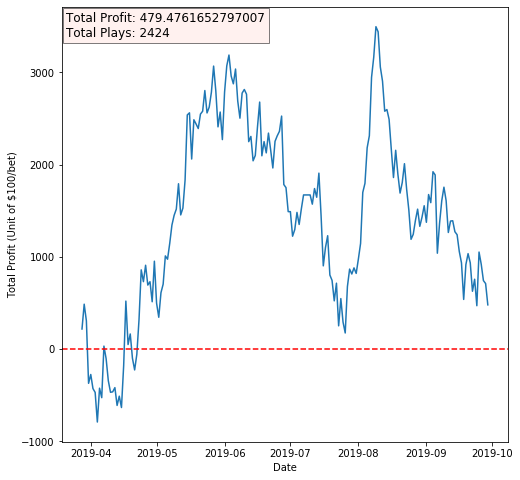

In [105]:
from bankroll_calc import BankrollCalculator

bc = BankrollCalculator(p, test_target, test_dates, hcTest, rcTest)

bc.plot_profit()

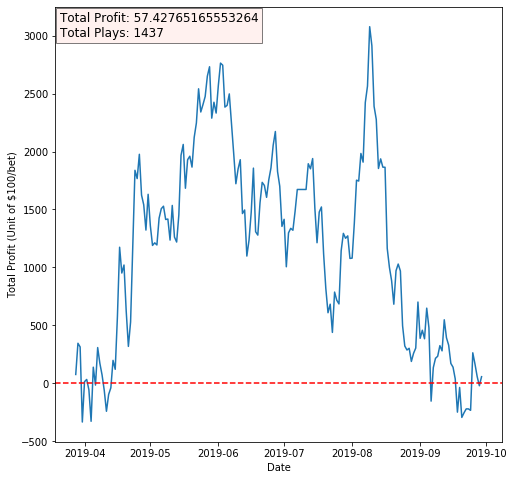

In [104]:
from bankroll_calc import BankrollCalculator

bc = BankrollCalculator(a, arb_df.home_win, arb_df.date, arb_df.home_closing,
                        arb_df.road_closing)

bc.plot_profit()